In [ ]:
!pip install covidcast

In [ ]:
from datetime import date
import covidcast

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Tristan's Path
dataset = pd.read_csv('/content/drive/MyDrive/training_data.csv')
dataaset = dataset.copy()

In [ ]:
dataset

,time_value,geo_value,doctor_visits (t-1),outpatient_covid (t-1),hospital_admissions (t-1),hospital_admissionsclaims (t-1),confirmed_cases_prop (t-1),doctor_visits (t-2),outpatient_covid (t-2),hospital_admissions (t-2),hospital_admissionsclaims (t-2),confirmed_cases_prop (t-2),label
0,2020-02-22,6001,0.000000,0.011169,0.100903,0.113524,0.0,0.000000,0.012182,0.120272,0.110992,0.000000,0.000000
1,2020-02-22,6013,0.000000,0.011528,0.097979,0.118647,0.0,0.000000,0.012669,0.098062,0.118745,0.000000,0.000000
2,2020-02-22,6037,0.102249,0.002221,0.092971,0.104829,0.0,0.102826,0.002446,0.100812,0.111187,0.000000,0.000000
3,2020-02-22,6059,0.098592,0.003301,0.079441,0.093063,0.0,0.098592,0.003528,0.079474,0.091819,0.000000,0.000000
4,2020-02-22,6065,0.012824,0.011176,0.087820,0.090121,0.0,0.000000,0.012328,0.086867,0.090382,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2404,2020-09-27,6071,3.669759,0.209799,6.422002,3.880961,0.0,3.662651,0.183888,5.491649,3.657069,14.219629,37.108645
2405,2020-09-27,6073,3.232160,0.178928,5.407488,1.984030,0.0,3.434456,0.153158,5.308291,1.876802,12.131814,18.242654
2406,2020-09-27,6075,7.035193,0.286158,2.876024,1.154249,0.0,7.350537,0.271349,3.212283,1.512510,10.436175,11.910852
2407,2020-09-27,6081,3.026974,0.163244,5.329470,2.697026,0.0,3.209329,0.155770,6.374249,3.207936,9.262001,7.566142


In [ ]:
X = dataset.iloc[:, 2:-1]
y = dataset.iloc[:, -1]

### Random Forest Using RandomSearchCV as Hypertuning



In [ ]:
import sklearn.model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from math import sqrt

n_splitss = 5
tscv = TimeSeriesSplit(n_splits=n_splitss)
#Split out 10% of original data for Test
test_size = round(len(X)*0.1)
XTrainVal = X[:-test_size]
X_test = X[-test_size:]
yTrainVal = y[:-test_size]
y_test = y[-test_size:]
forest = RandomForestRegressor(random_state=1)

In [ ]:
from sklearn.model_selection import GridSearchCV

forest = RandomForestRegressor(random_state = 1) # So we can get the same result after each run
parameters = {
    'bootstrap' : [True, False],
    'max_depth' : [3, 5, 10, 15, 20, None],
    'max_features' : ['auto', 'sqrt', 'log2'],
    'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]
}
tscv = TimeSeriesSplit(n_splits = n_splitss)
gsearch = GridSearchCV(estimator=forest, cv=tscv, param_grid=parameters, 
                       scoring = 'neg_mean_squared_error', return_train_score=True)
gsearch.fit(XTrainVal, yTrainVal)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [ ]:
records = {}
print("The Best Estimator across all searched parameters are are: \n ", best_model)
print("Random Forest Train MSE: ", -gsearch.cv_results_['mean_train_score'].mean())
print("Random Forest Validation MSE: ", -gsearch.cv_results_['mean_test_score'].mean())
print("Random Forest Test MSE: ", -gsearch.score(X_test, y_test))
#gsearch.cv_results_
records['Random Forest'] = [-gsearch.cv_results_['mean_train_score'].mean(),
                        -gsearch.cv_results_['mean_test_score'].mean(), 
                        -gsearch.score(X_test, y_test)]

The Best Estimator across all searched parameters are are: 
  RandomForestRegressor(n_estimators=15, random_state=1)
Random Forest Train MSE:  3.7576349660502317
Random Forest Validation MSE:  75.7088200821028
Random Forest Test MSE:  48.57810561376407


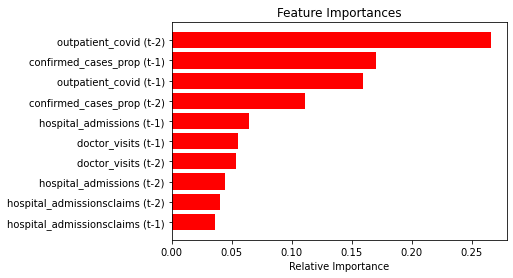

In [ ]:
feat_importance = best_model.feature_importances_
features = X.columns
indices = np.argsort(feat_importance)
plt.title('Feature Importances')
plt.barh(range(len(indices)), feat_importance[indices], color = 'red', align = 'center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

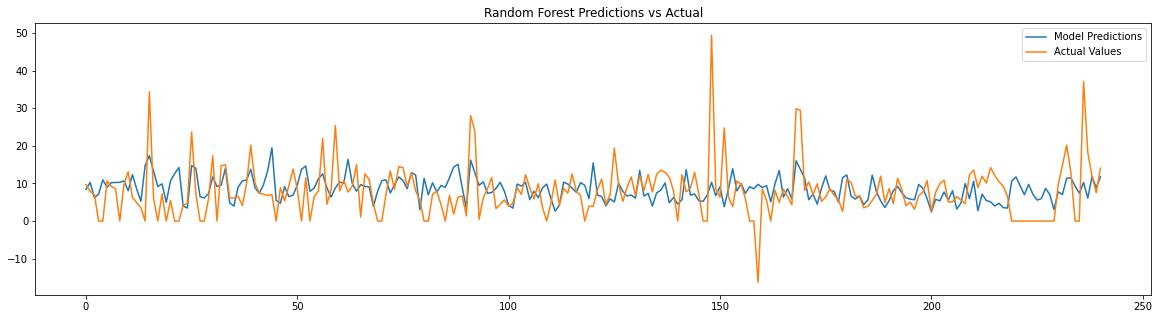

In [ ]:
predictTest = gsearch.predict(X_test)
plt.figure(figsize=(20,5))
plt.plot(predictTest)
plt.plot(y_test.values)
plt.title('Random Forest Predictions vs Actual')
plt.legend(["Model Predictions", "Actual Values"])

### How Random Forest Model Performs on Counties

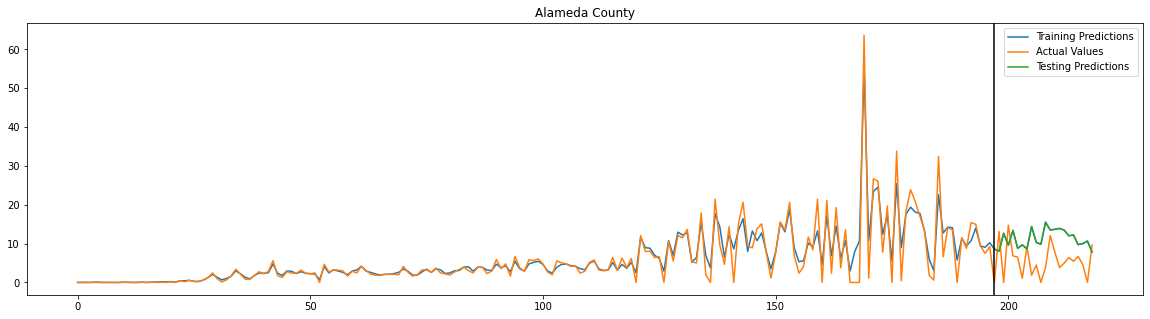

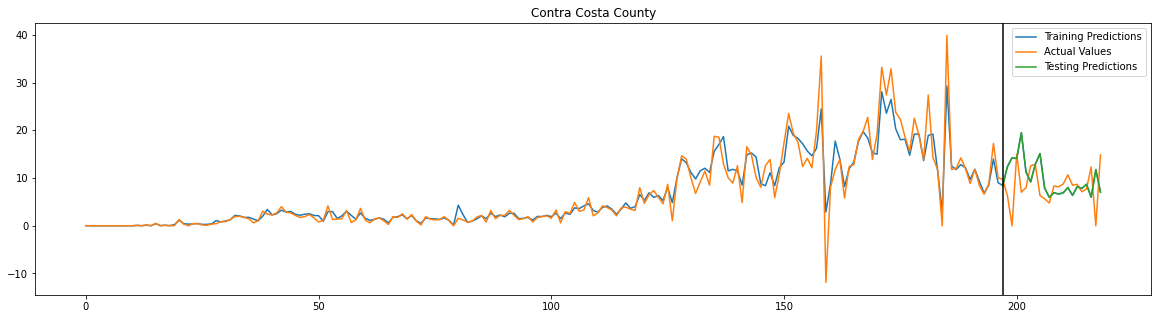

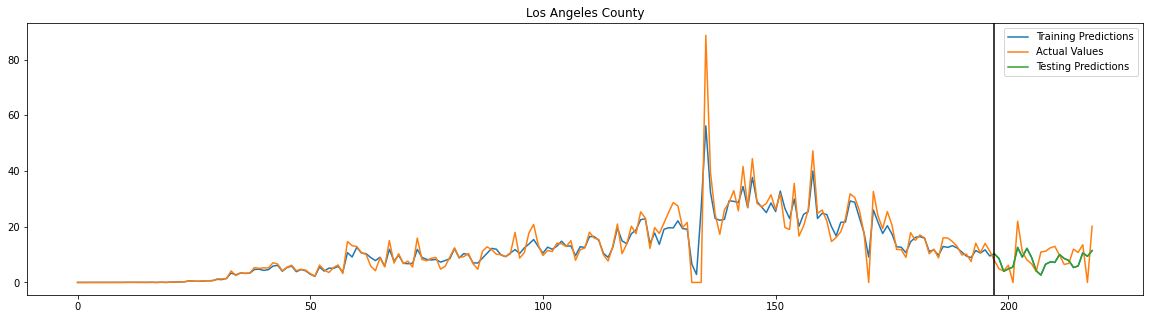

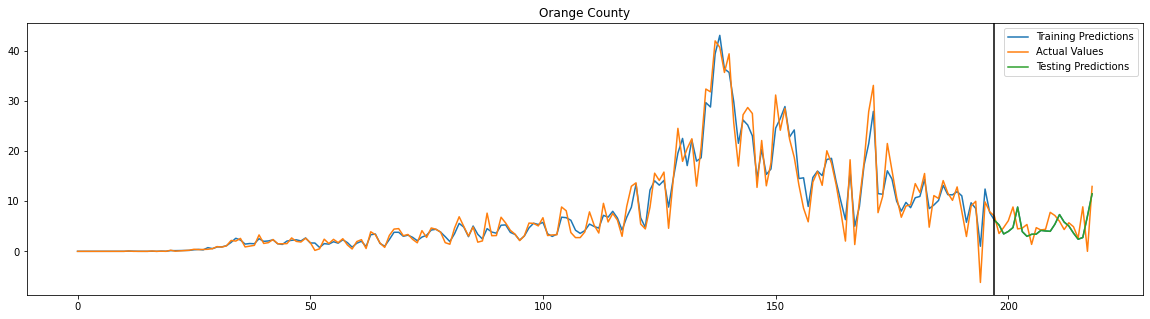

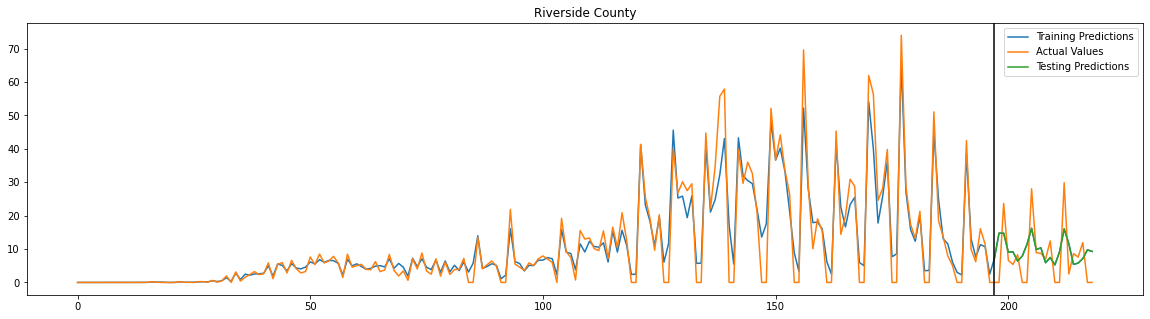

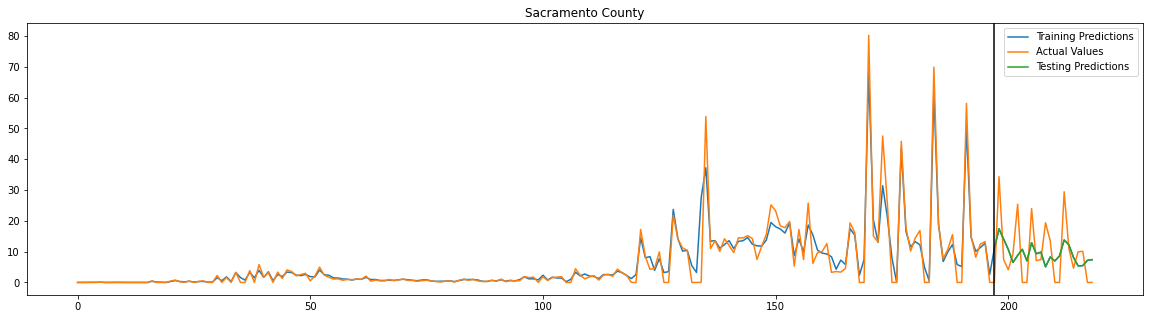

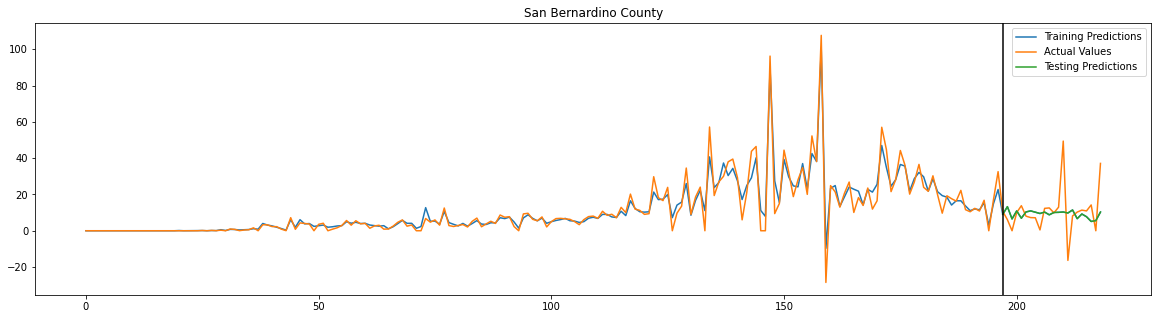

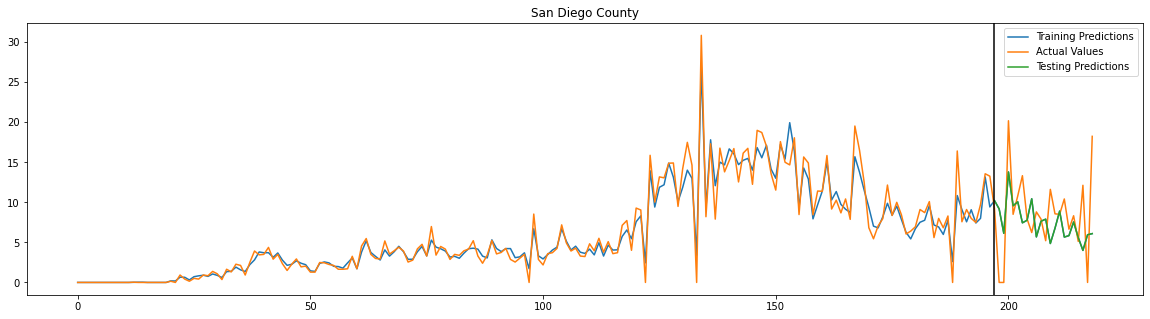

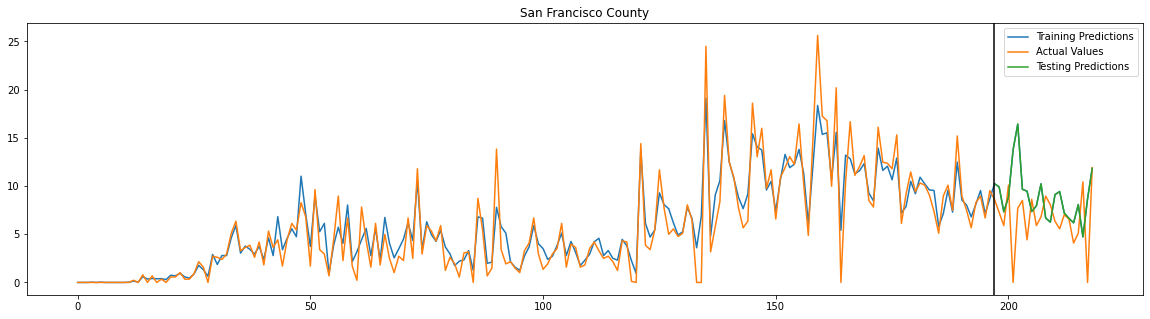

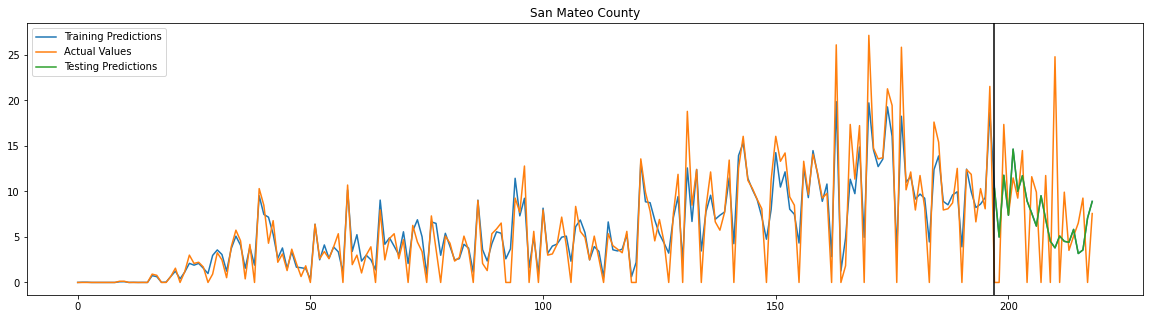

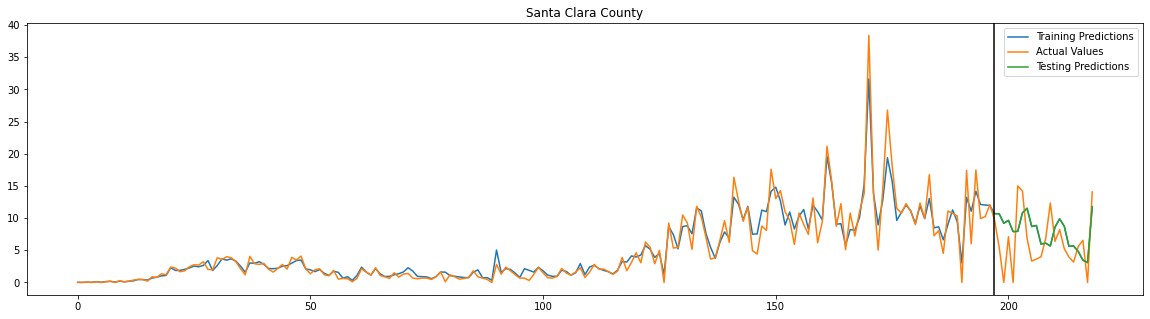

In [ ]:
random_forest_error = []
for i in dataaset.geo_value.unique():
  v = '0' + str(i)
  v = covidcast.fips_to_name(v)[0]
  county = dataaset.loc[dataaset.loc[:,'geo_value'] == i]
  countyX = county.iloc[:, 2:-1]
  countyy = county.iloc[:, -1]
  #ctest_size = round(len(countyX)*0.15)
  #countyXx = X[-ctest_size:]
  #countyY = y[-ctest_size:] 
  random_forest_error.append([v, -gsearch.score(countyX, countyy.values)])
  countyPredict = gsearch.predict(countyX)
  countyTest = countyPredict.copy()
  for i in range(round(len(countyPredict) * 0.9)):
    countyTest[i] = np.NaN
  plt.figure(figsize=(20,5))
  plt.plot(countyPredict)
  plt.plot(countyy.values)
  plt.plot(countyTest)
  plt.axvline(x = round(len(countyPredict) * 0.9), color = 'k')
  plt.legend(["Training Predictions", "Actual Values", "Testing Predictions"])
  plt.title(v)

In [ ]:
table1 = pd.DataFrame(random_forest_error, columns=['County', 'Mean Squared Error'])
table1

,County,Mean Squared Error
0,Alameda County,11.606074
1,Contra Costa County,8.297957
2,Los Angeles County,16.152994
3,Orange County,4.180814
4,Riverside County,24.217224
5,Sacramento County,19.068712
6,San Bernardino County,31.157887
7,San Diego County,3.952542
8,San Francisco County,4.667971
9,San Mateo County,7.943343


### Support Vector Machine (Non-Linear)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt


scaler = MinMaxScaler()
timegeolabel = dataset[['time_value', 'geo_value', 'label']]
X = dataset.iloc[:, 2:-1]
X = scaler.fit_transform(X)
y = dataset.iloc[:, -1]

test_size = round(len(X) * 0.1)
Xtrainval = X[:-test_size]
Xtest = X[-test_size:]
ytrainval = y[:-test_size]
ytest = y[-test_size:]
testtimegeo = timegeolabel[-test_size:]
testtimegeo.reset_index(drop = True, inplace = True)


tscv = TimeSeriesSplit(n_splits=5)

svr = SVR()

gs = GridSearchCV(svr, 
                  param_grid= {'kernel': ['rbf', 'poly'], 'C': [10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
                  scoring="neg_mean_squared_error", cv=tscv, verbose=1, return_train_score=True,)

gs.fit(Xtrainval, ytrainval)
svr1 = SVR(**gs.best_params_)
svr1.fit(Xtrainval, ytrainval)

y_pred = pd.DataFrame(svr1.predict(Xtest))
y_pred.rename(columns = {0:'Predictions'}, inplace = True)
testtimegeo1 = pd.concat((testtimegeo, y_pred), axis = 1)

y_train_pred = pd.DataFrame(svr1.predict(Xtrainval))
y_train_pred.rename(columns = {0:'Train Predictions'}, inplace = True)
timegeolabel = pd.concat((timegeolabel, y_train_pred), axis = 1)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [ ]:
results = pd.DataFrame(gs.cv_results_)
results = results[['params', 'mean_train_score', 'mean_test_score']]
results['mean_train_score'] = results['mean_train_score'].abs()  # Take absolute value of negative mean squared error
results['mean_test_score'] = results['mean_test_score'].abs()
results.rename(columns = {'params':'Parameters', 'mean_train_score':'Mean Training Performance (MSE)', 'mean_test_score':'Mean Validation Score (MSE)'}, inplace = True)

In [ ]:
results 

,Parameters,Mean Training Performance (MSE),Mean Validation Score (MSE)
0,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}",11.575946,81.419982
1,"{'C': 10, 'gamma': 1, 'kernel': 'poly'}",14.331814,118.017296
2,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",12.419171,83.893990
3,"{'C': 10, 'gamma': 0.1, 'kernel': 'poly'}",19.897760,137.870809
4,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",14.563973,99.073327
5,"{'C': 10, 'gamma': 0.01, 'kernel': 'poly'}",26.760291,158.739152
6,"{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}",20.572786,135.653922
7,"{'C': 10, 'gamma': 0.001, 'kernel': 'poly'}",26.775507,158.773645
8,"{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}",25.844130,155.751225
9,"{'C': 10, 'gamma': 0.0001, 'kernel': 'poly'}",26.775523,158.773679


In [ ]:
from sklearn.metrics import mean_squared_error
print('Test Mean Squared Error: {}'.format(mean_squared_error(ytest, y_pred)))

Test Mean Squared Error: 65.28124186385433


In [ ]:
print("The Best Estimator across all searched parameters are are: \n ", gs.best_estimator_)
print("Support Vector Machine Train MSE: ", -gs.cv_results_['mean_train_score'].mean())
print("Support Vector Machine Validation MSE: ", -gs.cv_results_['mean_test_score'].mean())
print("Support Vector Machine Test MSE: ", -gs.score(Xtest, ytest))
records['SVR'] = [-gs.cv_results_['mean_train_score'].mean(),
                  -gs.cv_results_['mean_test_score'].mean(),
                  -gs.score(Xtest, ytest)]

The Best Estimator across all searched parameters are are: 
  SVR(C=100, gamma=1)
Support Vector Machine Train MSE:  18.209153796010742
Support Vector Machine Validation MSE:  121.08562360682754
Support Vector Machine Test MSE:  65.28124186385433


In [ ]:
records1 = pd.DataFrame.from_dict(records, orient = 'index', columns = ['Train Score', 'Val Score', 'Test Score'])
records1

,Train Score,Val Score,Test Score
Random Forest,3.757635,75.708820,48.578106
SVR,18.209154,121.085624,65.281242


In [ ]:
# Merge true labels for entire dataset with predicted labels for test data

mergedf = pd.merge(timegeolabel, testtimegeo1, on = ['time_value', 'geo_value'], how = 'outer')

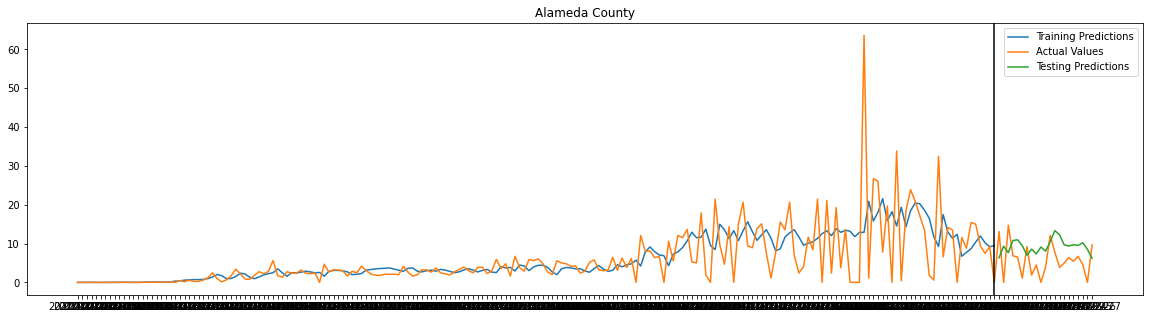

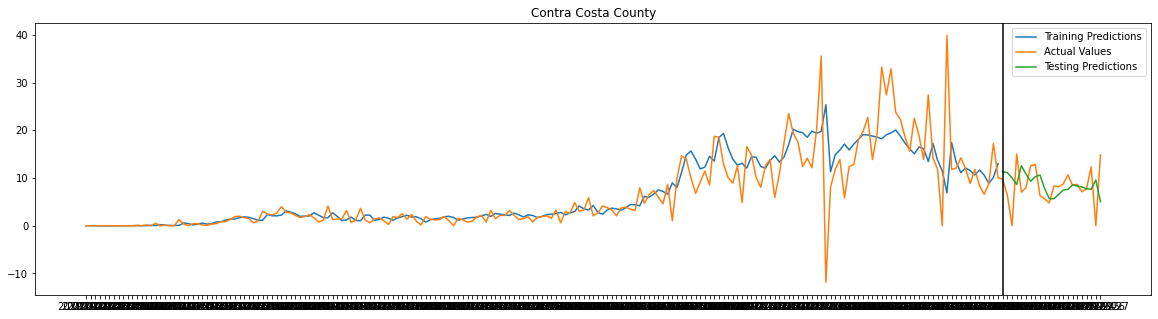

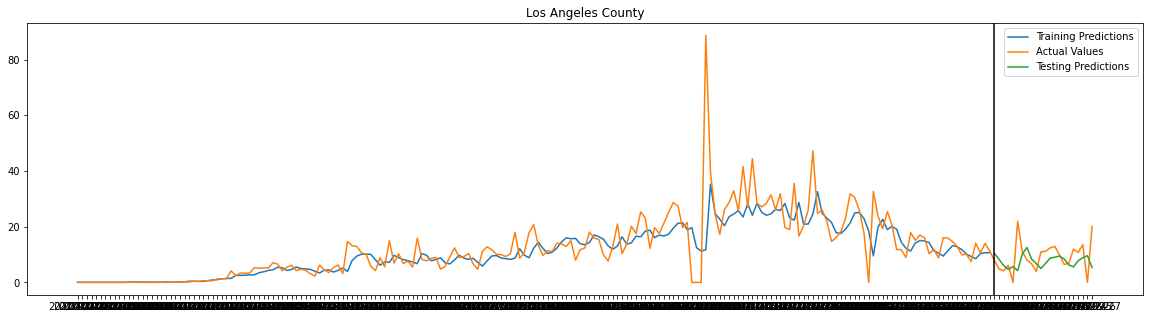

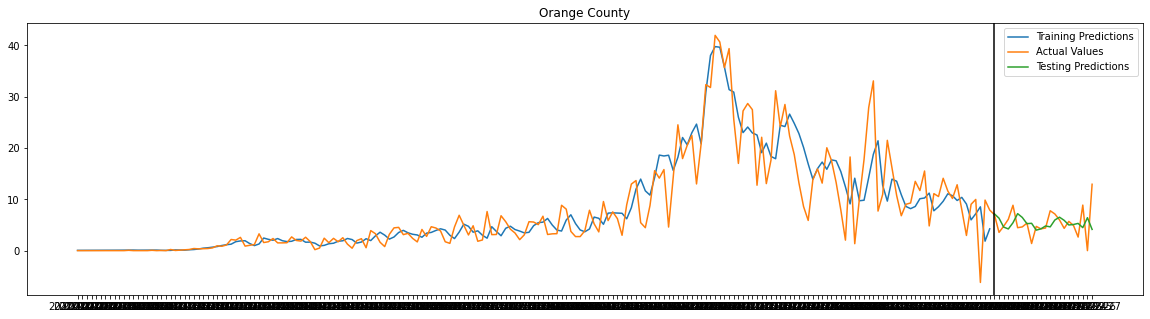

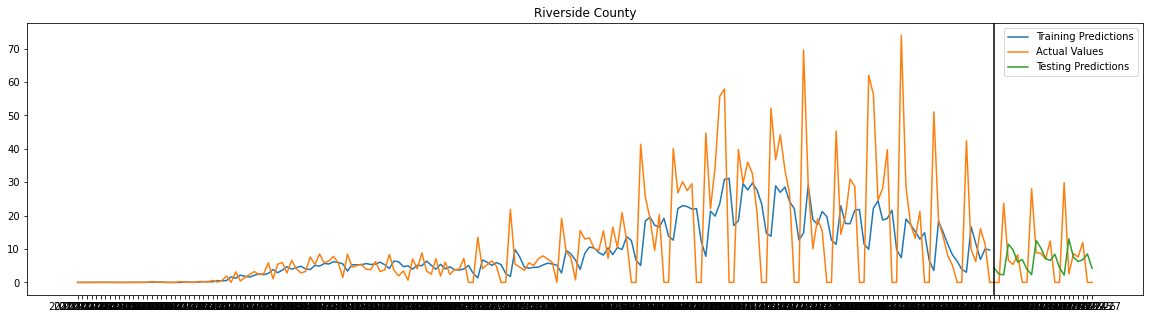

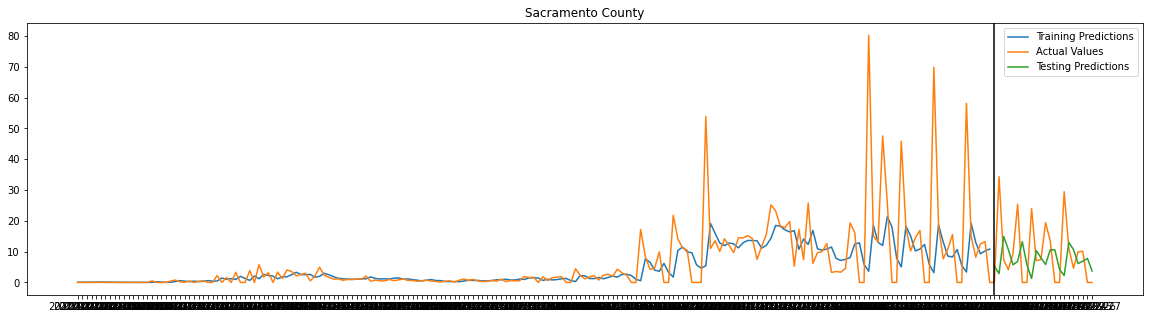

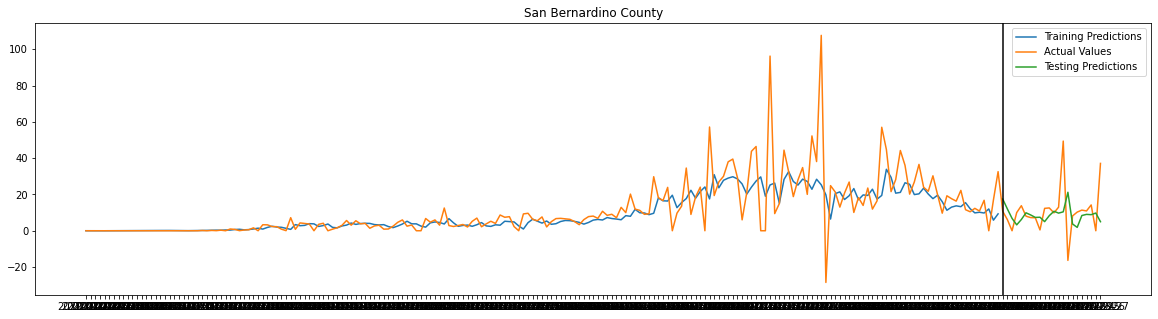

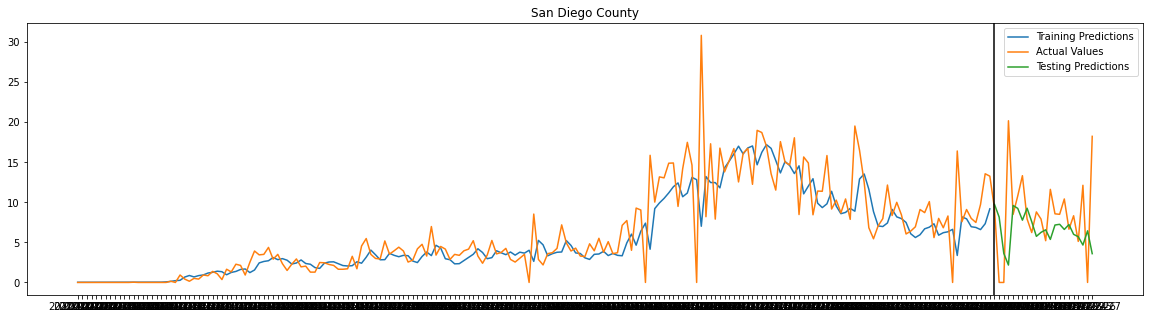

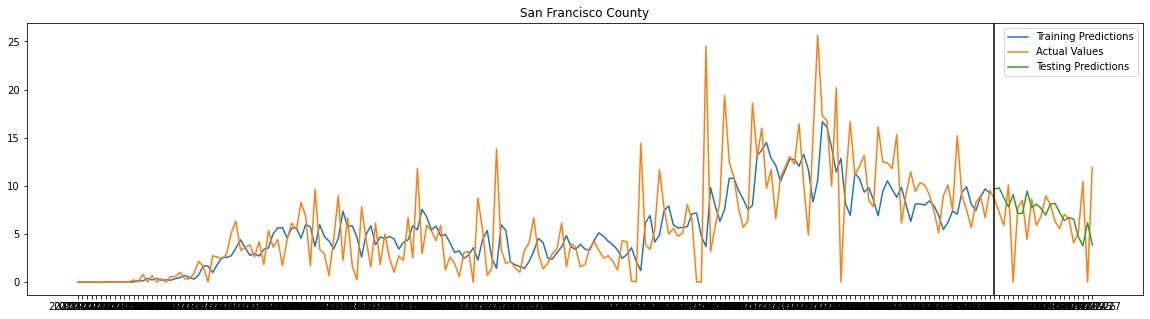

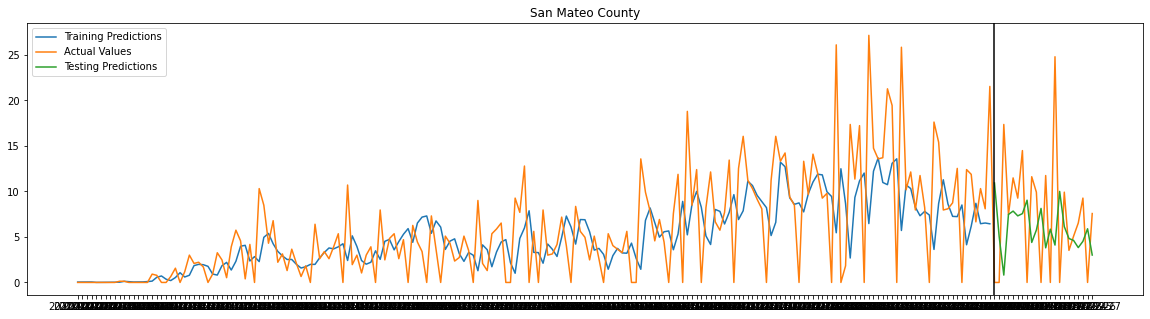

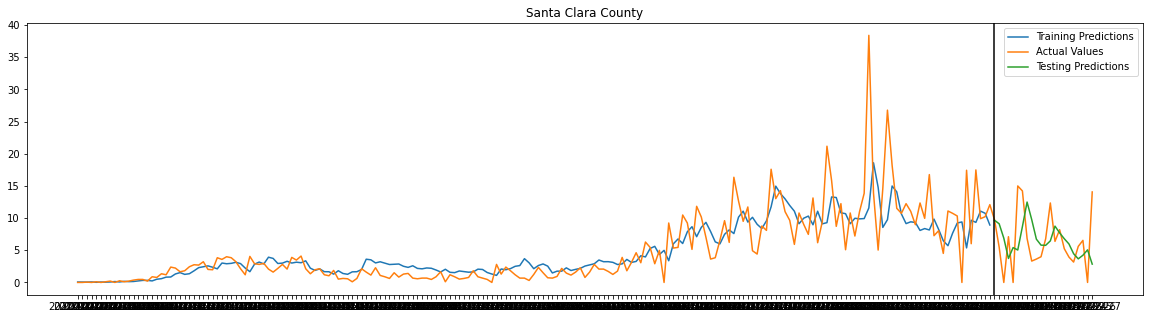

In [ ]:
import matplotlib.dates as mdates

for i, j in mergedf.groupby('geo_value'):
  v = '0' + str(i)
  v = covidcast.fips_to_name(v)[0]
  plt.figure(figsize=(20, 5))
  plt.title(v)
  plt.plot(j.time_value, j['Train Predictions'])
  plt.plot(j.time_value, j.label_x)
  plt.plot(j.time_value, j.Predictions)
  plt.legend(['Training Predictions', 'Actual Values', 'Testing Predictions'])
  plt.axvline(x = testtimegeo.iloc[1, :].time_value, color = 'k')
